# Gesture Recognition
In this project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly.

In [26]:
import numpy as np
import os
# from scipy.misc import imread, imresize
from skimage import io
from skimage.transform import resize
import datetime
import os
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
import importlib

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Input, Dropout, GlobalAveragePooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

In [27]:
class DataLoader:
    def __init__(self):
        self.train_doc = None
        self.val_doc = None

    def load_data(self, data_dir):
        self.train_doc = np.random.permutation(open(f'{data_dir}/train.csv').readlines())
        self.val_doc = np.random.permutation(open(f'{data_dir}/val.csv').readlines())

    def get_data(self, data_dir):
        self.load_data(data_dir)

        return self.train_doc, self.val_doc

In [28]:
class DataGenerator:
    def __init__(self, source_path, folder_list, batch_size, seq_len, y_dim, z_dim, num_labels, ablation=None, debug=False, image_debug=False, sort_images=False):
        self.source_path = source_path
        self.folder_list = folder_list
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.num_labels = num_labels
        self.ablation = ablation
        self.debug = debug
        self.image_debug = image_debug
        self.total_frames = 30
        self.sort_images = sort_images

    def process_images(self, folder_name, img_indices):
        if self.debug or self.image_debug:
            plt.figure(figsize=(20, 7))  
            plt.suptitle(f'Processing Images from {folder_name}')  # Setting the overall title for subplots

        imgs = os.listdir(self.source_path + '/' + folder_name)
        if self.debug:
            print(f"Images: {imgs}")

        batch_data = np.zeros((len(img_indices), self.y_dim, self.z_dim, 3))
        for idx, item in enumerate(img_indices):
            img_path = f"{self.source_path}/{folder_name}/{imgs[item]}"
            image = io.imread(img_path).astype(np.float32)

            if self.debug or self.image_debug:
                plt.subplot(3, len(img_indices), idx + 1)  # Adjust subplot grid for original images
                plt.imshow(image.astype('uint8'))
                plt.title("Original Image")

            # Apply cropping to make the image square
            if image.shape[0] != image.shape[1]:
                min_dim = min(image.shape[:2])
                start_x = (image.shape[1] - min_dim) // 2
                start_y = (image.shape[0] - min_dim) // 2
                image = image[start_y:start_y + min_dim, start_x:start_x + min_dim]

            if self.debug or self.image_debug:
                plt.subplot(3, len(img_indices), len(img_indices) + idx + 1)  # Adjust subplot grid for cropped images
                plt.imshow(image.astype('uint8'))
                plt.title("Cropped Image")

            # Resize the image after cropping
            resized_im = resize(image, output_shape=(self.y_dim, self.z_dim))
            batch_data[idx, :, :, 0] = resized_im[:, :, 0] / 255
            batch_data[idx, :, :, 1] = resized_im[:, :, 1] / 255
            batch_data[idx, :, :, 2] = resized_im[:, :, 2] / 255

            if self.debug or self.image_debug:
                plt.subplot(3, len(img_indices), 2 * len(img_indices) + idx + 1)  # Adjust subplot grid for resized images
                plt.imshow(resized_im.astype('uint8'))
                plt.title("Resized Image")

        return batch_data
    
    def generator(self):
        if self.debug:
            print('Source path = ', self.source_path, '; batch size =', self.batch_size)

        img_idx = rn.sample(range(self.total_frames), self.seq_len)
        if self.sort_images:
            img_idx = sorted(img_idx)
        print(f"\nimg_index : {img_idx}\n")

        while True:
            t = np.random.permutation(self.folder_list)
            if self.ablation is not None:
                t = t[:self.ablation]

            num_batches = (len(t) // self.batch_size) + (1 if len(t) % self.batch_size != 0 else 0)

            for batch in range(num_batches):
                current_batch_size = min(self.batch_size, len(t) - batch * self.batch_size)  # Calculate the actual size of the current batch
                batch_data = np.zeros((current_batch_size, len(img_idx), self.y_dim, self.z_dim, 3), dtype=np.float32)
                batch_labels = np.zeros((current_batch_size, self.num_labels), dtype=int)  # Initialize labels inside the loop for the actual batch size

                if self.debug:
                    print(f"Processing batch {batch + 1}/{num_batches}")

                for folder in range(current_batch_size):  # Use the actual batch size here
                    folder_index = folder + (batch * self.batch_size)
                    folder_name = t[folder_index].split(';')[0]
                    label_index = int(t[folder_index].split(';')[2].strip())
                    batch_labels[folder, label_index] = 1  # Set the correct label

                    if self.debug:
                        print(f"Label for folder {folder}: {label_index}")  # Debugging statement
                        print(f"Folder processed: {folder_name}")

                    batch_data[folder] = self.process_images(folder_name, img_idx)

                # Yielding the processed batch
                yield batch_data, batch_labels

In [29]:
data_dir = "/home/datasets/Project_data"
if not os.path.exists(data_dir):
    raise "Please set Project_data path in data_dir before using the notebook"

Source path =  /home/datasets/Project_data/train ; batch size = 64

img_index : [17, 4, 25, 20, 21, 6, 18, 14, 26, 3]

Processing batch 1/1
Label for folder 0: 4
Folder processed: WIN_20180926_16_56_13_Pro_Thumbs_Up_new
Images: ['WIN_20180926_16_56_13_Pro_00037.png', 'WIN_20180926_16_56_13_Pro_00034.png', 'WIN_20180926_16_56_13_Pro_00040.png', 'WIN_20180926_16_56_13_Pro_00035.png', 'WIN_20180926_16_56_13_Pro_00042.png', 'WIN_20180926_16_56_13_Pro_00044.png', 'WIN_20180926_16_56_13_Pro_00043.png', 'WIN_20180926_16_56_13_Pro_00019.png', 'WIN_20180926_16_56_13_Pro_00039.png', 'WIN_20180926_16_56_13_Pro_00033.png', 'WIN_20180926_16_56_13_Pro_00031.png', 'WIN_20180926_16_56_13_Pro_00023.png', 'WIN_20180926_16_56_13_Pro_00024.png', 'WIN_20180926_16_56_13_Pro_00038.png', 'WIN_20180926_16_56_13_Pro_00030.png', 'WIN_20180926_16_56_13_Pro_00028.png', 'WIN_20180926_16_56_13_Pro_00025.png', 'WIN_20180926_16_56_13_Pro_00015.png', 'WIN_20180926_16_56_13_Pro_00017.png', 'WIN_20180926_16_56_13_Pro_000

(array([[[[[0.19215687, 0.17254902, 0.1764706 ],
           [0.18431373, 0.16862746, 0.17254902],
           [0.18039216, 0.16862746, 0.17254902],
           ...,
           [0.5882353 , 0.63529414, 0.627451  ],
           [0.5647059 , 0.61960787, 0.6117647 ],
           [0.56078434, 0.6156863 , 0.60784316]],
 
          [[0.19215687, 0.17254902, 0.1764706 ],
           [0.19215687, 0.17254902, 0.1764706 ],
           [0.18039216, 0.16862746, 0.17254902],
           ...,
           [0.5882353 , 0.63529414, 0.627451  ],
           [0.5764706 , 0.62352943, 0.6156863 ],
           [0.57254905, 0.6156863 , 0.6117647 ]],
 
          [[0.18039216, 0.16862746, 0.17254902],
           [0.18039216, 0.16862746, 0.17254902],
           [0.18039216, 0.17254902, 0.16470589],
           ...,
           [0.5803922 , 0.6156863 , 0.62352943],
           [0.59607846, 0.6313726 , 0.627451  ],
           [0.5647059 , 0.6       , 0.59607846]],
 
          ...,
 
          [[0.50980395, 0.44313726, 0.411764

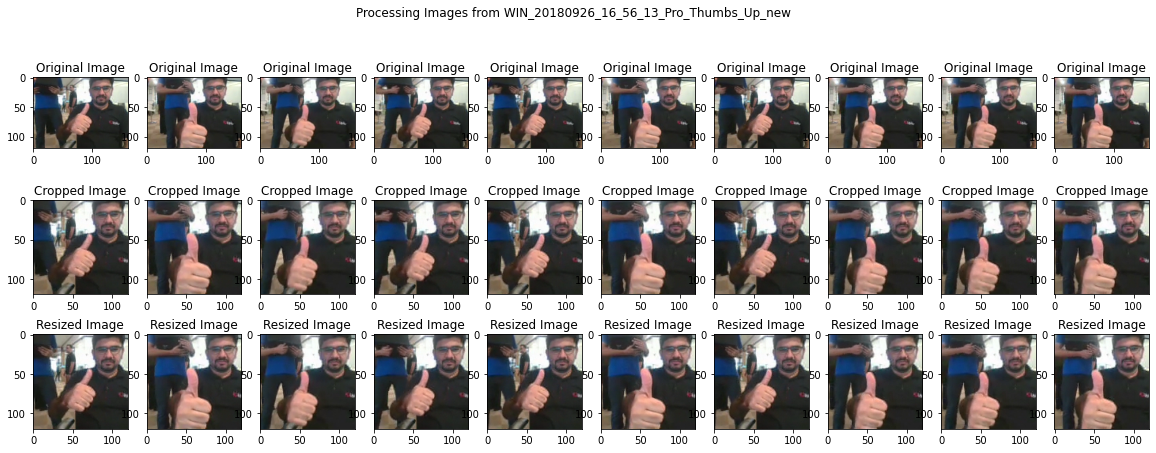

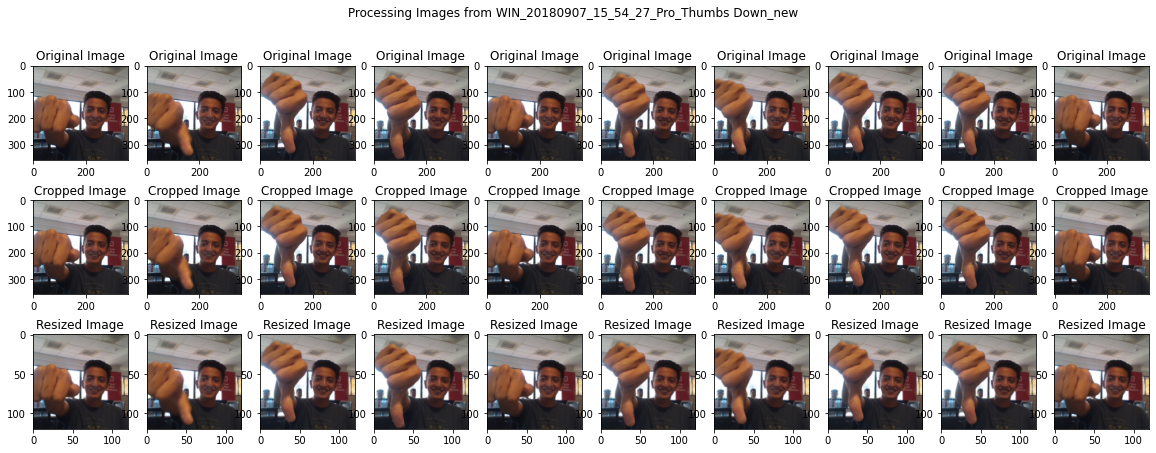

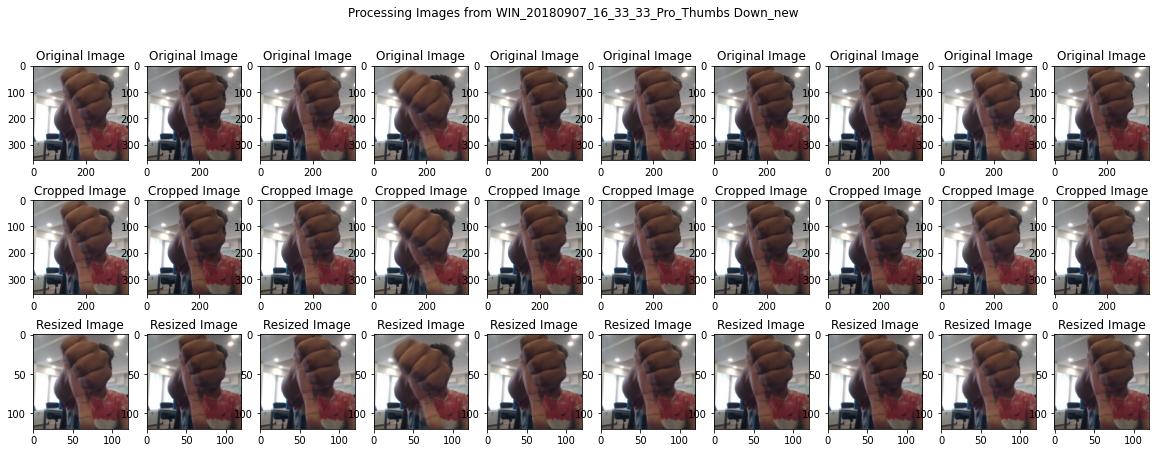

In [20]:
# Testing data generator

train_doc = np.random.permutation(open(f'{data_dir}/train.csv').readlines())
val_doc = np.random.permutation(open(f'{data_dir}/val.csv').readlines())
data_gen = DataGenerator(source_path=f'{data_dir}/train', folder_list=train_doc, batch_size=64, seq_len=10, y_dim=120, z_dim=120, num_labels=5, ablation=3, debug=True, image_debug=True)
train_gen = data_gen.generator()
next(train_gen)

In [30]:
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, factor=0.1, patience=10, min_lr=1e-7, warmup_epochs=None, 
                 warmup_initial_lr=None, warmup_target_lr=None, decrease_lr_post_warmup=True):
        super(CustomLearningRateScheduler, self).__init__()
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.epoch_counter = 0
        self.warmup_epochs = warmup_epochs
        self.warmup_initial_lr = warmup_initial_lr
        self.warmup_target_lr = warmup_target_lr
        self.decrease_lr_post_warmup = decrease_lr_post_warmup

    def on_epoch_begin(self, epoch, logs=None):
        is_warmup_epoch_enabled = self.warmup_epochs and self.warmup_initial_lr and self.warmup_target_lr
        if is_warmup_epoch_enabled  and epoch < self.warmup_epochs:
            scaling_factor = 0.01  # Slow down the increase
            new_lr = self.warmup_initial_lr + (self.warmup_target_lr - self.warmup_initial_lr) * ((epoch / self.warmup_epochs) * scaling_factor)
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
            print(f"\nEpoch {epoch + 1}: Setting learning rate to {new_lr}.")
        elif is_warmup_epoch_enabled and epoch == self.warmup_epochs:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.warmup_target_lr)
            print(f"\nEpoch {epoch + 1}: Forcing learning rate to {self.warmup_target_lr}.")
        elif self.patience:
            self.epoch_counter += 1
            if self.epoch_counter == self.patience:
                new_lr = max(self.model.optimizer.lr * self.factor, self.min_lr)
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                print(f"\nEpoch {epoch + 1}: Reducing learning rate to {new_lr}.")
            elif self.epoch_counter > self.patience:
                self.epoch_counter = 0  # Reset the counter after reduction


In [31]:
class ModelManager:
    def __init__(self, output_path, input_shape, num_labels):
        self.output_path = output_path
        self.input_shape = input_shape
        self.num_labels = num_labels
        self.model = None

    def build(self, model_name):
        method_name = 'build_' + model_name
        method = getattr(self, method_name, self.model_not_found)
        return method()

    def model_not_found(self):
        print("Model not found.")
        
    def build(self, model_name, learning_rate):
        # Dynamically import the build function based on model_name
        try:
            # Try to import the module
            module = importlib.import_module(model_name)
            
            # Reload the module to ensure any changes are picked up
            importlib.reload(module)
            
            # Get the build_model function from the module
            build_func = getattr(module, 'build_model')
            
            # Build the model using build_model function
            self.model = build_func(self.input_shape, self.num_labels, learning_rate)
            self.model_name = model_name
        
        except ModuleNotFoundError:
            print(f"Module '{model_name}' not found.")
        
        except AttributeError:
            print(f"Function 'build_model' not found in module '{model_name}'.")

    def train(self, train_generator, val_generator, num_train_steps, num_val_steps, num_epochs,
             warmup_epochs, warmup_initial_lr, warmup_target_lr, decrease_lr_post_warmup, save_prefix,
             lr_patience):

        if not os.path.exists(self.output_path):
            os.mkdir(self.output_path)
        
        filepath = os.path.join(self.output_path, f'{save_prefix}-{{epoch:05d}}-{{loss:.5f}}-{{categorical_accuracy:.5f}}-{{val_loss:.5f}}-{{val_categorical_accuracy:.5f}}.h5')
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        custom_lr = CustomLearningRateScheduler(factor=0.75, patience=lr_patience, min_lr=1e-8,
                                    warmup_epochs=warmup_epochs, warmup_initial_lr=warmup_initial_lr, 
                                    warmup_target_lr=warmup_target_lr, decrease_lr_post_warmup=decrease_lr_post_warmup)
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
        callbacks_list = [checkpoint, custom_lr, early_stopping]

        return self.model.fit(train_generator, steps_per_epoch=num_train_steps, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, validation_steps=num_val_steps)

In [32]:
class Trainer:
    def __init__(self, batch_size, seq_len, y_dim, z_dim, output_path,  
                 ablation=None, debug=False, image_debug=False, model_name=None, 
                 learning_rate=0.01, num_epochs=1, warmup_epochs=None, warmup_initial_lr=None, 
                 warmup_target_lr=None, decrease_lr_post_warmup=True, save_prefix=None, sort_images=False,
                 lr_patience=None):
        
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.ablation = ablation
        self.debug = debug
        self.image_debug = image_debug
        self.model_name = model_name
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.warmup_epochs = warmup_epochs
        self.warmup_initial_lr = warmup_initial_lr
        self.warmup_target_lr = warmup_target_lr
        self.decrease_lr_post_warmup = decrease_lr_post_warmup
        self.sort_images=sort_images
        self.lr_patience = lr_patience
        
        if save_prefix:
            self.save_prefix = save_prefix
        else:
            self.save_prefix = model_name

        self.output_path = output_path
        self.model = None

        self.input_shape = (seq_len, y_dim, z_dim, 3)

        # Setting the seed for NumPy-generated random numbers
        np.random.seed(30)

        # Setting the seed for Python random numbers
        rn.seed(30)

        # Setting the seed for TensorFlow random numbers
        # tf.set_random_seed(30)
        tf.random.set_seed(30)

        self.data_dir = data_dir
        self.train_doc, self.val_doc = self.get_docs()

        self.num_labels = self.get_num_labels(self.train_doc, self.val_doc)
    
    def get_docs(self):
        data_loader = DataLoader()
        train_doc, val_doc = data_loader.get_data(self.data_dir)

        return train_doc, val_doc

    def get_num_labels(self, train_doc, val_doc):
        # Example of iterating over each line in train_doc
        unique_batch_labels = set()
        for line in train_doc:
            # Process each line
            # Usually, lines from a CSV are comma-separated, so you might want to split the line
            data = line.strip().split(';')
            # Now 'data' is a list where each item corresponds to a value from the CSV line
            # Example processing: print or use the data
            #print(data)  # This is just an example; replace with your actual processing code
            batch_label = data[2]
            unique_batch_labels.add(batch_label)

        print(f"Unique labels : {unique_batch_labels}")
        num_labels = len(unique_batch_labels)
        print(f"Total number of unique labels : {num_labels}")

        return num_labels


    def get_num_steps(self, train_doc, val_doc):
        num_train_sequences = len(train_doc)
        print('# training sequences =', num_train_sequences)      
        num_val_sequences = len(val_doc)
        print('# validation sequences =', num_val_sequences)  

        if self.ablation is not None:
            num_train_sequences = self.ablation
            num_val_sequences = self.ablation


        if (num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (num_train_sequences//self.batch_size) + 1

        if (num_val_sequences%self.batch_size) == 0:
            validation_steps = int(num_val_sequences/self.batch_size)
        else:
            validation_steps = (num_val_sequences//self.batch_size) + 1

        return steps_per_epoch, validation_steps
    
    def build(self):
        self.model = ModelManager(self.output_path, self.input_shape, self.num_labels)
        self.model.build(self.model_name, self.learning_rate)

    def train(self):

        train_generator = DataGenerator(source_path=f'{self.data_dir}/train', folder_list=self.train_doc, batch_size=self.batch_size, seq_len=self.seq_len, 
                                 y_dim=self.y_dim, z_dim=self.z_dim, num_labels=self.num_labels, 
                                 ablation=self.ablation, debug=self.debug, image_debug=self.image_debug, sort_images=self.sort_images).generator()
        val_generator = DataGenerator(source_path=f'{self.data_dir}/val', folder_list=self.val_doc, batch_size=self.batch_size, seq_len=self.seq_len, 
                                 y_dim=self.y_dim, z_dim=self.z_dim, num_labels=self.num_labels, 
                                 ablation=self.ablation, debug=self.debug, image_debug=self.image_debug, sort_images=self.sort_images).generator()

        steps_per_epoch, validation_steps = self.get_num_steps(train_doc=self.train_doc, val_doc=self.val_doc)
        
        self.history = self.model.train(train_generator, val_generator, steps_per_epoch, validation_steps, self.num_epochs,
                                    self.warmup_epochs, self.learning_rate, self.warmup_target_lr, 
                                    self.decrease_lr_post_warmup, self.save_prefix, self.lr_patience)

    def plot_training_history(self, epochs=30):
        acc = self.history.history['categorical_accuracy']
        val_acc = self.history.history['val_categorical_accuracy']
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        # Ensure the epoch range matches the length of the historical data
        epochs_range = range(1, self.num_epochs + 1)  # Correct the range to include all epochs

        plt.figure(figsize=(20, 8))
        # Plot training and validation accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.xticks(list(epochs_range))  # Ensuring x-axis has integer labels and matches the epoch range

        # Plot training and validation loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xticks(list(epochs_range))  # Ensuring x-axis has integer labels and matches the epoch range
        plt.show()

## Experiments with Conv3d models

### Experiment 1 
- Kicking off training with image dimesnion set to 160x160 and ablation set to 10.

In [11]:
trainer = Trainer(batch_size=128, seq_len=20, y_dim=160, z_dim=160, output_path="best_models", 
                 ablation=10, debug=False, image_debug=False, model_name="model_1", learning_rate=0.001, num_epochs=20,
                 save_prefix="test_exp_1")
trainer.build()

Unique labels : {'2', '0', '3', '1', '4'}
Total number of unique labels : 5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_2 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_3 (Batc  (None, 20, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                            

In [17]:
#trainer.train()
# This model failed with the OOM resource exhausted error. Removing the stack trace as it is huge

#### Conclusion
This model failed with the OOM resource exhausted error. batch_size must be set to a smaller value

### Experiment 2 
- Let's reduce the batch size to a smaller value like 20

In [14]:
trainer = Trainer(batch_size=20, seq_len=20, y_dim=160, z_dim=160, output_path="best_models", 
                 ablation=10, debug=False, image_debug=False, model_name="model_1", learning_rate=0.001, num_epochs=20,
                 save_prefix="test_exp_2")
trainer.build()

Unique labels : {'2', '0', '3', '1', '4'}
Total number of unique labels : 5
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_6 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_9 (Batc  (None, 20, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                            

In [15]:
trainer.train()

# training sequences = 663
# validation sequences = 100

img_index : [17, 25, 9, 19, 0, 26, 20, 6, 8, 1, 12, 24, 4, 2, 14, 28, 21, 3, 15, 23]

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 2.7911 - categorical_accuracy: 0.2000
img_index : [5, 26, 28, 19, 16, 12, 20, 11, 17, 2, 24, 0, 7, 8, 13, 9, 1, 10, 4, 27]


Epoch 00001: val_loss improved from inf to 15.74236, saving model to best_models/test_exp_2-00001-2.79109-0.20000-15.74236-0.20000.h5
1/1 [==============================] - 7s 7s/step - loss: 2.7911 - categorical_accuracy: 0.2000 - val_loss: 15.7424 - val_categorical_accuracy: 0.2000
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 1.8312 - categorical_accuracy: 0.4000
Epoch 00002: val_loss improved from 15.74236 to 5.35340, saving model to best_models/test_exp_2-00002-1.83120-0.40000-5.35340-0.40000.h5
1/1 [==============================] - 8s 8s/step - loss: 1.8312 - categorical_accuracy: 0.4000 - val_loss: 5.3534 - val_categorical_accurac

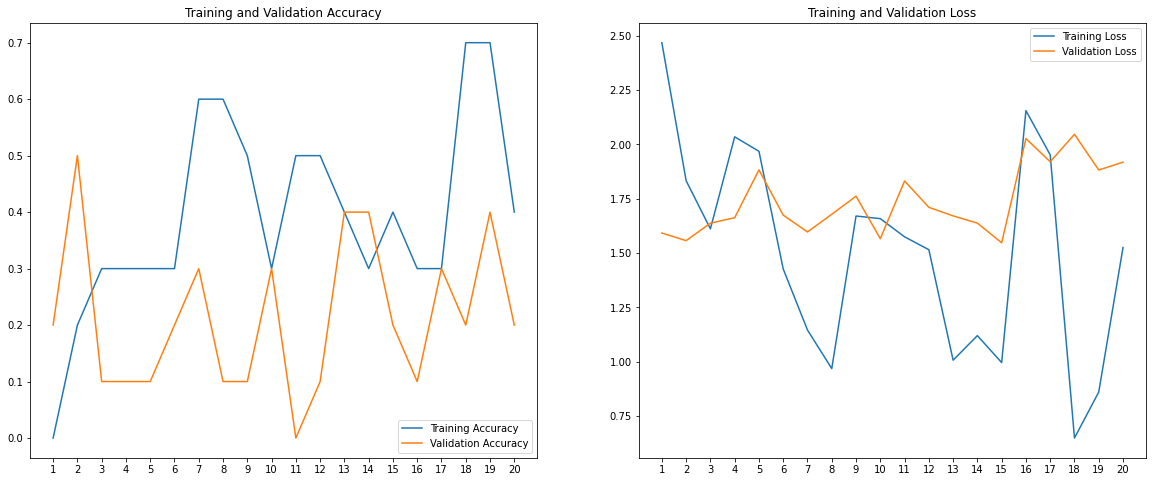

In [28]:
trainer.plot_training_history()

#### Conclusion
- Model is clearly not learning anything. Let's increase the ablation size to half of the total data

### Experiment 3 

- Setting ablation size to half of the total sequences

In [16]:
trainer = Trainer(batch_size=20, seq_len=20, y_dim=160, z_dim=160, output_path="best_models", 
                 ablation=300, debug=False, image_debug=False, model_name="model_1", learning_rate=0.001, num_epochs=20,
                 save_prefix="test_exp_3")
trainer.build()

Unique labels : {'2', '0', '3', '1', '4'}
Total number of unique labels : 5
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                            

In [17]:
trainer.train()

# training sequences = 663
# validation sequences = 100

img_index : [17, 25, 9, 19, 0, 26, 20, 6, 8, 1, 12, 24, 4, 2, 14, 28, 21, 3, 15, 23]

Epoch 1/20
15/15 [==============================] - ETA: 0s - loss: 1.6583 - categorical_accuracy: 0.4367
img_index : [5, 26, 28, 19, 16, 12, 20, 11, 17, 2, 24, 0, 7, 8, 13, 9, 1, 10, 4, 27]


Epoch 00001: val_loss improved from inf to 3.25357, saving model to best_models/test_exp_2-00001-1.65831-0.43667-3.25357-0.18000.h5
15/15 [==============================] - 98s 7s/step - loss: 1.6583 - categorical_accuracy: 0.4367 - val_loss: 3.2536 - val_categorical_accuracy: 0.1800
Epoch 2/20
15/15 [==============================] - ETA: 0s - loss: 0.8781 - categorical_accuracy: 0.6833
Epoch 00002: val_loss improved from 3.25357 to 2.26599, saving model to best_models/test_exp_2-00002-0.87808-0.68333-2.26599-0.21667.h5
15/15 [==============================] - 98s 7s/step - loss: 0.8781 - categorical_accuracy: 0.6833 - val_loss: 2.2660 - val_categorical_a

#### Conclusion
- The model is definitely learning this time, but it's mostly overfitting and struggling to generalize, as shown by the validation accuracy.

### Experiment 4 

Let’s try this:

- Increase model complexity
    - Add more convolutional layers with dropouts
- Run for 10 epochs

In [22]:
trainer = Trainer(batch_size=20, seq_len=20, y_dim=160, z_dim=160, output_path="best_models", 
                 ablation=300, debug=False, image_debug=False, model_name="model_2", learning_rate=0.001, num_epochs=10,
                 save_prefix="test_exp_4")
trainer.build()

Unique labels : {'2', '0', '3', '1', '4'}
Total number of unique labels : 5
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_14 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_21 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_15 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                            

In [23]:
trainer.train()

# training sequences = 663
# validation sequences = 100

img_index : [17, 25, 9, 19, 0, 26, 20, 6, 8, 1, 12, 24, 4, 2, 14, 28, 21, 3, 15, 23]

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 1.9148 - categorical_accuracy: 0.2967
img_index : [5, 26, 28, 19, 16, 12, 20, 11, 17, 2, 24, 0, 7, 8, 13, 9, 1, 10, 4, 27]


Epoch 00001: val_loss improved from inf to 1.60114, saving model to best_models/test_exp_4-00001-1.91475-0.29667-1.60114-0.25000.h5
15/15 [==============================] - 122s 9s/step - loss: 1.9148 - categorical_accuracy: 0.2967 - val_loss: 1.6011 - val_categorical_accuracy: 0.2500
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: 1.3988 - categorical_accuracy: 0.4633
Epoch 00002: val_loss did not improve from 1.60114
15/15 [==============================] - 110s 8s/step - loss: 1.3988 - categorical_accuracy: 0.4633 - val_loss: 2.2354 - val_categorical_accuracy: 0.2367
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss:

#### Conclusion

- Boosting the model complexity didn’t solve the generalization problem.

### Experiment 5 
 - Let’s arrange the randomly selected video frames in sequential order to maintain the temporal aspect and test the impact.

In [24]:
trainer = Trainer(batch_size=20, seq_len=20, y_dim=160, z_dim=160, output_path="best_models", 
                 ablation=300, debug=False, image_debug=False, model_name="test_model_2", learning_rate=0.001, num_epochs=10,
                 save_prefix="test_exp_5", sort_images=True)
trainer.build()

Unique labels : {'2', '0', '3', '1', '4'}
Total number of unique labels : 5
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_18 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_27 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                            

In [25]:
trainer.train()

# training sequences = 663
# validation sequences = 100

img_index : [0, 1, 2, 3, 4, 6, 8, 9, 12, 14, 15, 17, 19, 20, 21, 23, 24, 25, 26, 28]

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 1.9383 - categorical_accuracy: 0.2933
img_index : [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 24, 26, 27, 28]


Epoch 00001: val_loss improved from inf to 1.64647, saving model to best_models/test_exp_5-00001-1.93831-0.29333-1.64647-0.27000.h5
15/15 [==============================] - 94s 7s/step - loss: 1.9383 - categorical_accuracy: 0.2933 - val_loss: 1.6465 - val_categorical_accuracy: 0.2700
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: 1.4820 - categorical_accuracy: 0.4600
Epoch 00002: val_loss did not improve from 1.64647
15/15 [==============================] - 93s 7s/step - loss: 1.4820 - categorical_accuracy: 0.4600 - val_loss: 2.4661 - val_categorical_accuracy: 0.1767
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss: 1

#### Conclusion
- Overfitting issue persists

### Experiment 6 
- let's run it for 20 epochs

In [27]:
trainer = Trainer(batch_size=20, seq_len=20, y_dim=160, z_dim=160, output_path="best_models", 
                 ablation=None, debug=False, image_debug=False, model_name="model_2", learning_rate=0.001, num_epochs=20,
                 save_prefix="test_exp_6", sort_images=True)
trainer.build()

Unique labels : {'2', '0', '3', '1', '4'}
Total number of unique labels : 5
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_26 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_26 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_37 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_26 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_27 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                           

In [28]:
trainer.train()

# training sequences = 663
# validation sequences = 100

img_index : [0, 1, 2, 3, 4, 6, 8, 9, 12, 14, 15, 17, 19, 20, 21, 23, 24, 25, 26, 28]

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7706 - categorical_accuracy: 0.3424
img_index : [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 24, 26, 27, 28]


Epoch 00001: val_loss improved from inf to 2.63303, saving model to best_models/test_exp_6-00001-1.77059-0.34238-2.63303-0.17000.h5
34/34 [==============================] - 118s 4s/step - loss: 1.7706 - categorical_accuracy: 0.3424 - val_loss: 2.6330 - val_categorical_accuracy: 0.1700
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.3684 - categorical_accuracy: 0.4495
Epoch 00002: val_loss did not improve from 2.63303
34/34 [==============================] - 115s 3s/step - loss: 1.3684 - categorical_accuracy: 0.4495 - val_loss: 3.6884 - val_categorical_accuracy: 0.1900
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss:

#### Conclusion

Significant improvement is noticeable from 15 epochs, but the model has some drawbacks:

- While validation loss has decreased, it fluctuates significantly between 0.5 and 0.8 as epochs progress.
- Validation loss doesn't decrease during the first 15 epochs.

### Experiment 7

- Let's implement a custom learning rate scheduler to adjust the learning rate every 3 epochs.

In [29]:
trainer = Trainer(batch_size=20, seq_len=20, y_dim=160, z_dim=160, output_path="best_models", 
                 ablation=None, debug=False, image_debug=False, model_name="model_2", learning_rate=0.001, num_epochs=20,
                 save_prefix="test_exp_8", sort_images=True, lr_patience=3)
trainer.build()

Unique labels : {'2', '0', '3', '1', '4'}
Total number of unique labels : 5
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_30 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_30 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_43 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_30 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_31 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                           

In [30]:
trainer.train()

# training sequences = 663
# validation sequences = 100

img_index : [0, 1, 2, 3, 4, 6, 8, 9, 12, 14, 15, 17, 19, 20, 21, 23, 24, 25, 26, 28]

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7751 - categorical_accuracy: 0.3469
img_index : [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 24, 26, 27, 28]


Epoch 00001: val_loss improved from inf to 2.17932, saving model to best_models/test_exp_8-00001-1.77506-0.34691-2.17932-0.21000.h5
34/34 [==============================] - 118s 4s/step - loss: 1.7751 - categorical_accuracy: 0.3469 - val_loss: 2.1793 - val_categorical_accuracy: 0.2100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.3256 - categorical_accuracy: 0.4781
Epoch 00002: val_loss did not improve from 2.17932
34/34 [==============================] - 115s 3s/step - loss: 1.3256 - categorical_accuracy: 0.4781 - val_loss: 3.0851 - val_categorical_accuracy: 0.1300

Epoch 3: Reducing learning rate to 0.000750000006519258.
Epoch 3/2

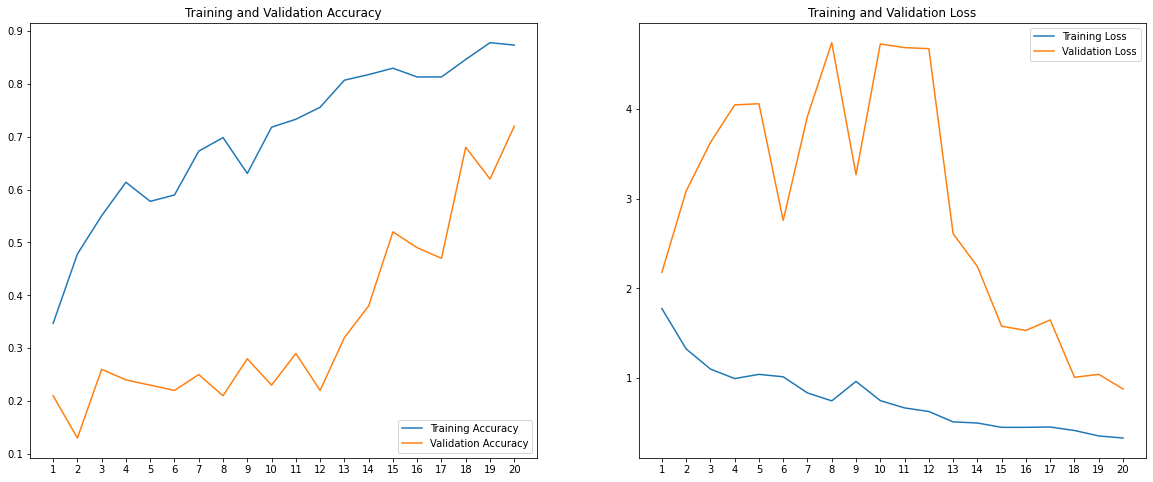

In [31]:
trainer.plot_training_history()

#### Conclusion

We noticed substantial improvement after adding the learning rate scheduler:

- Validation accuracy is stable in the later epochs.
- Validation loss consistently decreases after 15 epochs.
- Overfitting has been reduced, but it still exists.

### Experiment 8 

- Let's try the following:
    - Add kernel regularization with values of 0.01 and 0.1 to minimize overfitting.
    - Include all data.
    - Run for 30 epochs.


In [34]:
trainer = Trainer(batch_size=20, seq_len=20, y_dim=160, z_dim=160, output_path="best_models", 
                 ablation=None, debug=False, image_debug=False, model_name="model_3", learning_rate=0.001, num_epochs=30,
                 save_prefix="exp_8", sort_images=True, lr_patience=3)
trainer.build()

Unique labels : {'4', '2', '1', '3', '0'}
Total number of unique labels : 5
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_48 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                            

In [35]:
trainer.train()

# training sequences = 663
# validation sequences = 100

img_index : [0, 1, 2, 3, 4, 6, 8, 9, 12, 14, 15, 17, 19, 20, 21, 23, 24, 25, 26, 28]

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 22.2743 - categorical_accuracy: 0.3544
img_index : [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 24, 26, 27, 28]


Epoch 00001: val_loss improved from inf to 16.61346, saving model to best_models/exp_5-00001-22.27433-0.35445-16.61346-0.21000.h5
34/34 [==============================] - 116s 3s/step - loss: 22.2743 - categorical_accuracy: 0.3544 - val_loss: 16.6135 - val_categorical_accuracy: 0.2100
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 11.6087 - categorical_accuracy: 0.5023
Epoch 00002: val_loss improved from 16.61346 to 10.89680, saving model to best_models/exp_5-00002-11.60868-0.50226-10.89680-0.13000.h5
34/34 [==============================] - 114s 3s/step - loss: 11.6087 - categorical_accuracy: 0.5023 - val_loss: 10.8968 - val_categori

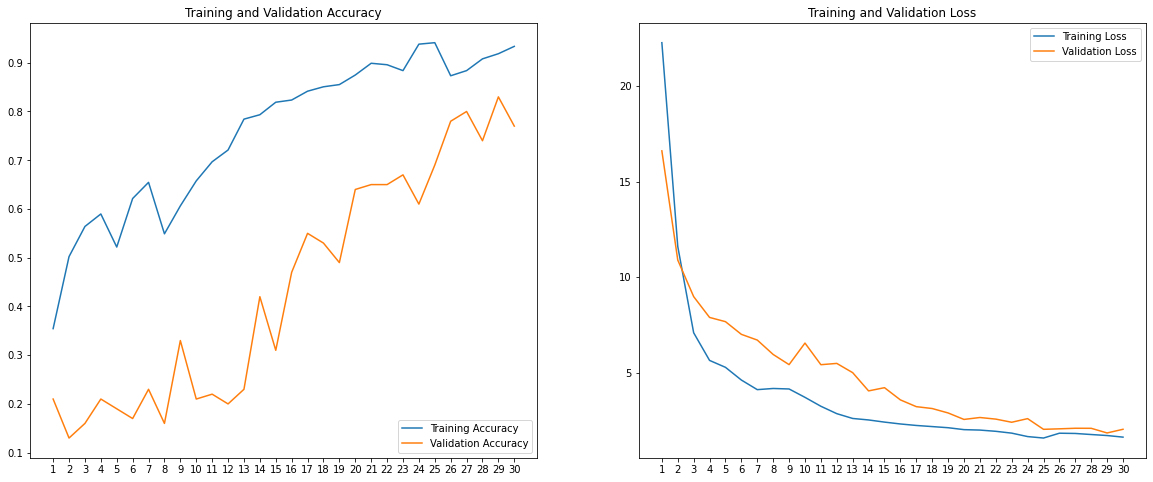

In [36]:
trainer.plot_training_history()

#### Conclusion

It’s working well, but there’s still some degree of overfitting.

### Experiment 9

- increasing l2 norm for both dense layers to 0.1

In [38]:
trainer = Trainer(batch_size=20, seq_len=20, y_dim=160, z_dim=160, output_path="best_models", 
                 ablation=None, debug=False, image_debug=False, model_name="model_4", learning_rate=0.001, num_epochs=30,
                 save_prefix="exp_9", sort_images=True, lr_patience=3)
trainer.build()

Unique labels : {'4', '2', '1', '3', '0'}
Total number of unique labels : 5
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_36 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_54 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_37 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                            

In [39]:
trainer.train()

# training sequences = 663
# validation sequences = 100

img_index : [0, 1, 2, 3, 4, 6, 8, 9, 12, 14, 15, 17, 19, 20, 21, 23, 24, 25, 26, 28]

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 31.4103 - categorical_accuracy: 0.3786
img_index : [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 24, 26, 27, 28]


Epoch 00001: val_loss improved from inf to 23.20295, saving model to best_models/exp_6-00001-31.41034-0.37858-23.20295-0.21000.h5
34/34 [==============================] - 213s 6s/step - loss: 31.4103 - categorical_accuracy: 0.3786 - val_loss: 23.2029 - val_categorical_accuracy: 0.2100
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 17.1373 - categorical_accuracy: 0.4465
Epoch 00002: val_loss improved from 23.20295 to 14.24295, saving model to best_models/exp_6-00002-17.13730-0.44646-14.24295-0.19000.h5
34/34 [==============================] - 163s 5s/step - loss: 17.1373 - categorical_accuracy: 0.4465 - val_loss: 14.2429 - val_categori

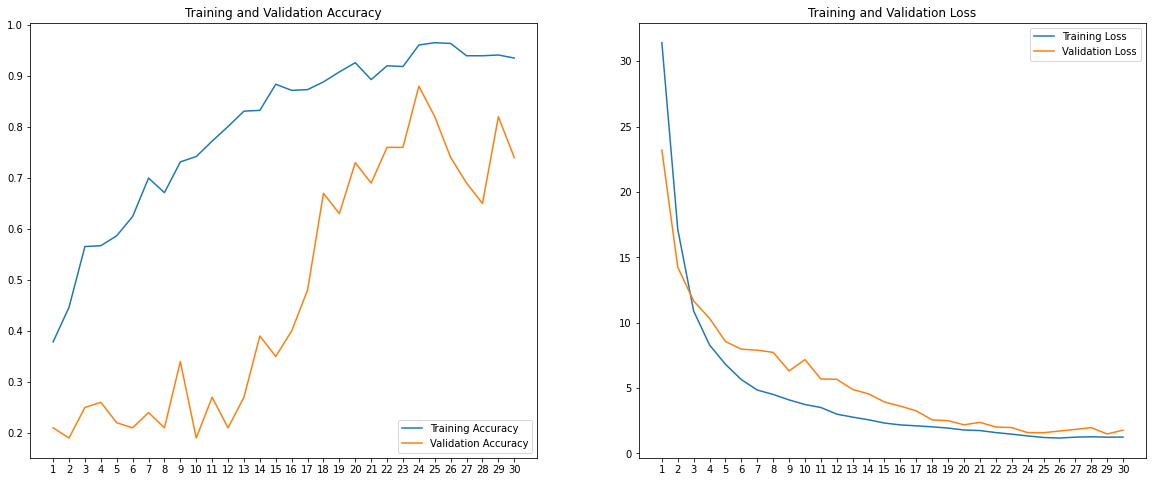

In [40]:
trainer.plot_training_history()

#### Conclusion

- We got much better accuracy this time training accuracy .96, validation accuracy .88
- but overfitting still exists, and validation accuracy is still under .9

### Experiment 10

- Increasing kernel regularizers to 0.15

In [9]:
trainer = Trainer(batch_size=20, seq_len=20, y_dim=160, z_dim=160, output_path="best_models", 
                 ablation=None, debug=False, image_debug=False, model_name="model_5", learning_rate=0.001, num_epochs=30,
                 save_prefix="exp_10", sort_images=True, lr_patience=3)
trainer.build()

Unique labels : {'3', '4', '0', '1', '2'}
Total number of unique labels : 5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                              

2024-06-29 15:30:24.558606: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-06-29 15:30:24.558670: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [10]:
trainer.train()

# training sequences = 663
# validation sequences = 100

img_index : [0, 1, 2, 3, 4, 6, 8, 9, 12, 14, 15, 17, 19, 20, 21, 23, 24, 25, 26, 28]

Epoch 1/30


2024-06-29 15:30:42.710445: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 42.5212 - categorical_accuracy: 0.3650
img_index : [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 24, 26, 27, 28]


Epoch 00001: val_loss improved from inf to 27.38395, saving model to best_models/exp_7-00001-42.52115-0.36501-27.38395-0.30000.h5
34/34 [==============================] - 116s 3s/step - loss: 42.5212 - categorical_accuracy: 0.3650 - val_loss: 27.3839 - val_categorical_accuracy: 0.3000
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 19.9384 - categorical_accuracy: 0.4615
Epoch 00002: val_loss improved from 27.38395 to 15.56587, saving model to best_models/exp_7-00002-19.93840-0.46154-15.56587-0.15000.h5
34/34 [==============================] - 113s 3s/step - loss: 19.9384 - categorical_accuracy: 0.4615 - val_loss: 15.5659 - val_categorical_accuracy: 0.1500

Epoch 3: Reducing learning rate to 0.000750000006519258.
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 12.1849

#### Conclusion 
 - So , increasing kernel regularizer couldn't boost the model performance.

### Experiment 11

- Let's try playing with kernel initializer, setting kernel initializers to he_normal

In [32]:
trainer = Trainer(batch_size=20, seq_len=20, y_dim=160, z_dim=160, output_path="best_models", 
                 ablation=None, debug=False, image_debug=False, model_name="model_6", learning_rate=0.001, num_epochs=30,
                 save_prefix="exp_11", sort_images=True, lr_patience=3)
trainer.build()

Unique labels : {'3', '4', '0', '1', '2'}
Total number of unique labels : 5
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                           

In [33]:
trainer.train()

# training sequences = 663
# validation sequences = 100

img_index : [0, 1, 2, 3, 4, 6, 8, 9, 12, 14, 15, 17, 19, 20, 21, 23, 24, 25, 26, 28]

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 42.2274 - categorical_accuracy: 0.3937
img_index : [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 24, 26, 27, 28]


Epoch 00001: val_loss improved from inf to 32.90477, saving model to best_models/exp_8-00001-42.22738-0.39367-32.90477-0.27000.h5
34/34 [==============================] - 115s 3s/step - loss: 42.2274 - categorical_accuracy: 0.3937 - val_loss: 32.9048 - val_categorical_accuracy: 0.2700
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 25.8133 - categorical_accuracy: 0.5053
Epoch 00002: val_loss improved from 32.90477 to 21.31927, saving model to best_models/exp_8-00002-25.81326-0.50528-21.31927-0.32000.h5
34/34 [==============================] - 113s 3s/step - loss: 25.8133 - categorical_accuracy: 0.5053 - val_loss: 21.3193 - val_categori

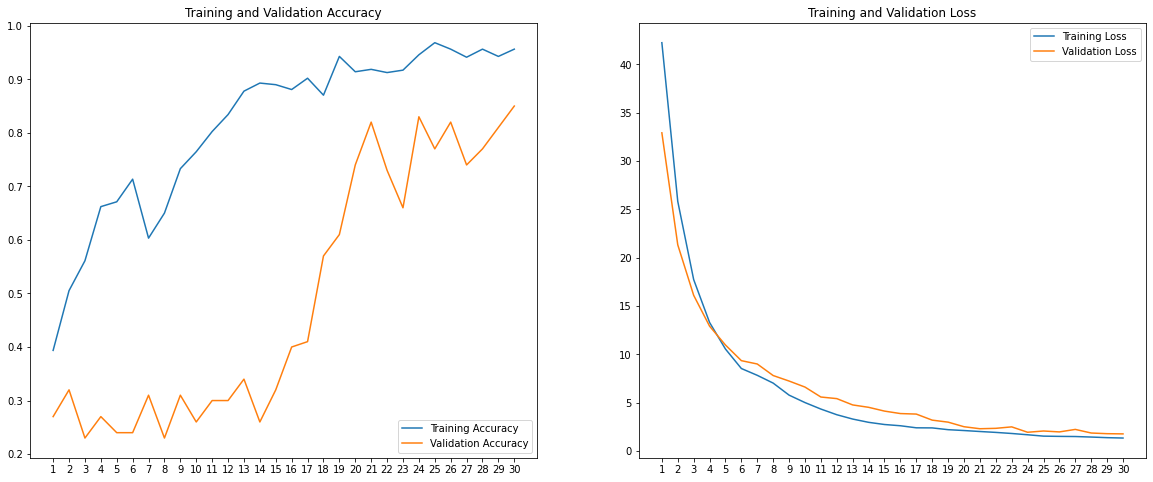

In [34]:
trainer.plot_training_history()

#### Conclusion

- Last few epochs showed constant increase in accuracy This seems to be a good model, although still a bit overfitting.

### Experiment 12

 - Let's see if we can handle the overfitting problem in it  by adding more dropouts

In [37]:
trainer = Trainer(batch_size=20, seq_len=20, y_dim=160, z_dim=160, output_path="best_models", 
                 ablation=None, debug=False, image_debug=False, model_name="model_7", learning_rate=0.001, num_epochs=30,
                 save_prefix="exp_12", sort_images=True, lr_patience=3)
trainer.build()

Unique labels : {'3', '4', '0', '1', '2'}
Total number of unique labels : 5
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_36 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                           

In [ ]:
trainer.train()

# training sequences = 663
# validation sequences = 100

img_index : [0, 1, 2, 3, 4, 6, 8, 9, 12, 14, 15, 17, 19, 20, 21, 23, 24, 25, 26, 28]

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 42.2110 - categorical_accuracy: 0.3439
img_index : [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 24, 26, 27, 28]


Epoch 00001: val_loss improved from inf to 31.47772, saving model to best_models/exp_9-00001-42.21099-0.34389-31.47772-0.22000.h5
34/34 [==============================] - 119s 4s/step - loss: 42.2110 - categorical_accuracy: 0.3439 - val_loss: 31.4777 - val_categorical_accuracy: 0.2200
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 25.0096 - categorical_accuracy: 0.5324
Epoch 00002: val_loss improved from 31.47772 to 21.00649, saving model to best_models/exp_9-00002-25.00956-0.53243-21.00649-0.25000.h5
34/34 [==============================] - 114s 3s/step - loss: 25.0096 - categorical_accuracy: 0.5324 - val_loss: 21.0065 - val_categori

In [ ]:
trainer.plot_training_history()

#### Conclusion

- jarvis got auto-paused during the training, but from the output it's evident that dropouts are not helping

### Experiment 13

- let's try reducing the temporal dimension 
    - Changing MaxPooling3D(pool_size=(2, 2, 2)) to MaxPooling3D(pool_size=(1, 2, 2))

In [8]:
trainer = Trainer(batch_size=20, seq_len=20, y_dim=160, z_dim=160, output_path="best_models", 
                 ablation=None, debug=False, image_debug=False, model_name="model_8", learning_rate=0.001, num_epochs=30,
                 save_prefix="exp_13", sort_images=True, lr_patience=3)
trainer.build()

Unique labels : {'4', '1', '3', '2', '0'}
Total number of unique labels : 5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                              

2024-06-29 19:39:16.766515: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-06-29 19:39:16.766574: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [9]:
trainer.train()

# training sequences = 663
# validation sequences = 100

img_index : [0, 1, 2, 3, 4, 6, 8, 9, 12, 14, 15, 17, 19, 20, 21, 23, 24, 25, 26, 28]

Epoch 1/30


2024-06-29 19:39:30.498236: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 50.5953 - categorical_accuracy: 0.4148
img_index : [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 24, 26, 27, 28]


Epoch 00001: val_loss improved from inf to 38.65817, saving model to best_models/exp_10-00001-50.59528-0.41478-38.65817-0.24000.h5
34/34 [==============================] - 119s 3s/step - loss: 50.5953 - categorical_accuracy: 0.4148 - val_loss: 38.6582 - val_categorical_accuracy: 0.2400
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 27.9410 - categorical_accuracy: 0.4284
Epoch 00002: val_loss improved from 38.65817 to 23.38154, saving model to best_models/exp_10-00002-27.94105-0.42836-23.38154-0.19000.h5
34/34 [==============================] - 125s 4s/step - loss: 27.9410 - categorical_accuracy: 0.4284 - val_loss: 23.3815 - val_categorical_accuracy: 0.1900

Epoch 3: Reducing learning rate to 0.000750000006519258.
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 18.66

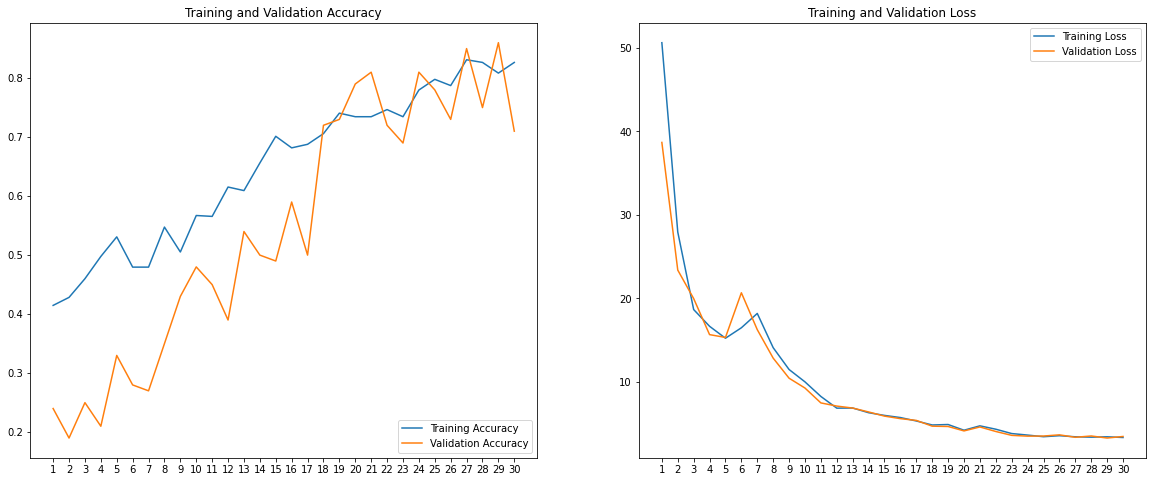

In [10]:
trainer.plot_training_history()

#### Conclusion

- As evident from the graph, with the change in maxpooling's temporal dimension, overfitting problem is largely reduced, although training accuracy has dropped slightly.

### Experiment 14

- Let's run it for 50 epochs

In [10]:
trainer = Trainer(batch_size=20, seq_len=20, y_dim=160, z_dim=160, output_path="best_models", 
                 ablation=None, debug=False, image_debug=False, model_name="model_8", learning_rate=0.001, num_epochs=50,
                 save_prefix="exp_14", sort_images=True, lr_patience=3)
trainer.build()

Unique labels : {'1', '2', '0', '3', '4'}
Total number of unique labels : 5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                              

2024-06-30 03:35:45.499016: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-06-30 03:35:45.499093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


In [11]:
trainer.train()

# training sequences = 663
# validation sequences = 100

img_index : [0, 1, 2, 3, 4, 6, 8, 9, 12, 14, 15, 17, 19, 20, 21, 23, 24, 25, 26, 28]

Epoch 1/50


2024-06-30 03:36:22.502848: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 50.7220 - categorical_accuracy: 0.4012
img_index : [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 24, 26, 27, 28]


Epoch 00001: val_loss improved from inf to 37.91441, saving model to best_models/exp_10_1-00001-50.72195-0.40121-37.91441-0.19000.h5
34/34 [==============================] - 162s 5s/step - loss: 50.7220 - categorical_accuracy: 0.4012 - val_loss: 37.9144 - val_categorical_accuracy: 0.1900
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 27.6341 - categorical_accuracy: 0.4284
Epoch 00002: val_loss improved from 37.91441 to 23.15202, saving model to best_models/exp_10_1-00002-27.63406-0.42836-23.15202-0.22000.h5
34/34 [==============================] - 130s 4s/step - loss: 27.6341 - categorical_accuracy: 0.4284 - val_loss: 23.1520 - val_categorical_accuracy: 0.2200

Epoch 3: Reducing learning rate to 0.000750000006519258.
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 1

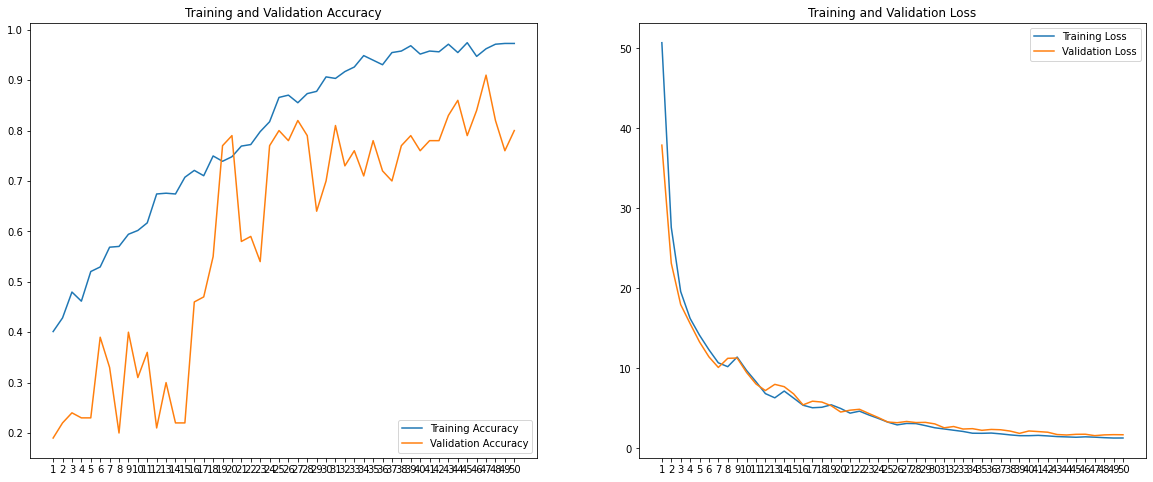

In [12]:
trainer.plot_training_history()

#### Concusion

- Awesome, we have a great model this time! We achieved 0.96 training accuracy and 0.91 validation accuracy. Reducing the temporal dimension in the MaxPooling3D layer really worked.

### Experiment 15

- let's see if we can decrease the number of parameters by replacing flatten() layer with a GlobalAveragePooling3D layer


In [23]:
trainer = Trainer(batch_size=20, seq_len=20, y_dim=160, z_dim=160, output_path="best_models", 
                 ablation=None, debug=False, image_debug=False, model_name="model_9", learning_rate=0.001, num_epochs=30,
                 save_prefix="exp_15", sort_images=True, lr_patience=3)
trainer.build()

Unique labels : {'4', '1', '3', '2', '0'}
Total number of unique labels : 5
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 20, 160, 160, 32)  2624      
                                                                 
 activation_28 (Activation)  (None, 20, 160, 160, 32)  0         
                                                                 
 batch_normalization_42 (Bat  (None, 20, 160, 160, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 20, 80, 80, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 20, 80, 80, 64)    55360     
                                            

In [24]:
trainer.train()

# training sequences = 663
# validation sequences = 100

img_index : [0, 1, 2, 3, 4, 6, 8, 9, 12, 14, 15, 17, 19, 20, 21, 23, 24, 25, 26, 28]

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 65.3583 - categorical_accuracy: 0.4042
img_index : [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 24, 26, 27, 28]


Epoch 00001: val_loss improved from inf to 56.60339, saving model to best_models/exp_11-00001-65.35828-0.40422-56.60339-0.23000.h5
34/34 [==============================] - 115s 3s/step - loss: 65.3583 - categorical_accuracy: 0.4042 - val_loss: 56.6034 - val_categorical_accuracy: 0.2300
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 43.0254 - categorical_accuracy: 0.4615
Epoch 00002: val_loss improved from 56.60339 to 35.98220, saving model to best_models/exp_11-00002-43.02538-0.46154-35.98220-0.26000.h5
34/34 [==============================] - 113s 3s/step - loss: 43.0254 - categorical_accuracy: 0.4615 - val_loss: 35.9822 - val_catego

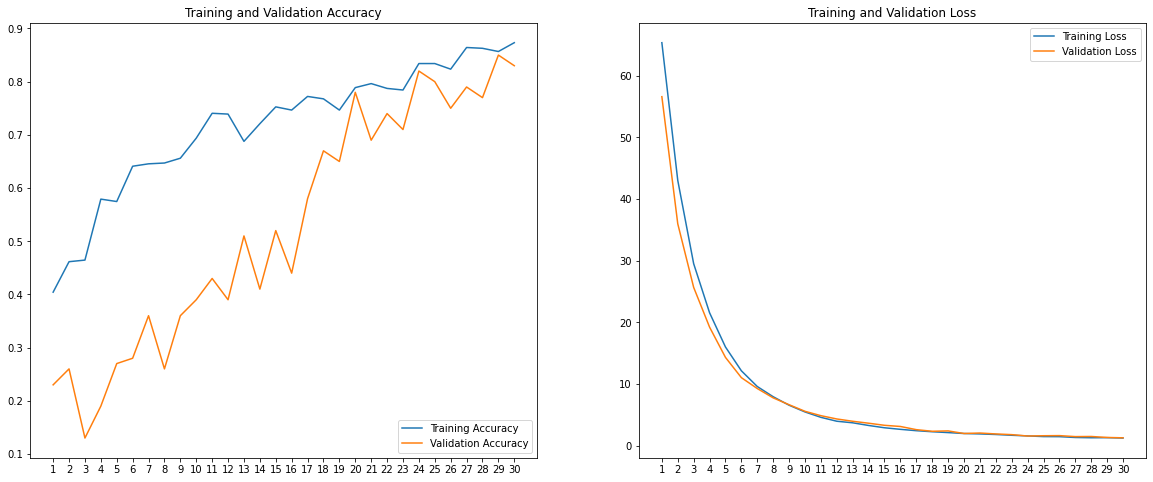

In [25]:
trainer.plot_training_history()

#### Conclusion

- We are able to decrease the parameters
- Also, this model doesn't show much overfitting in the high epochs

### Experiment 16

- Let's try it for 50 epochs

In [8]:
trainer = Trainer(batch_size=20, seq_len=20, y_dim=160, z_dim=160, output_path="best_models", 
                 ablation=None, debug=False, image_debug=False, model_name="model_9", learning_rate=0.001, num_epochs=50,
                 save_prefix="exp_11", sort_images=True, lr_patience=3)
trainer.build()

Unique labels : {'1', '3', '4', '2', '0'}
Total number of unique labels : 5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 32)  2624      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 32)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 64)    55360     
                                              

2024-06-30 11:37:18.090170: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-06-30 11:37:18.090228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [9]:
trainer.train()

# training sequences = 663
# validation sequences = 100

img_index : [0, 1, 2, 3, 4, 6, 8, 9, 12, 14, 15, 17, 19, 20, 21, 23, 24, 25, 26, 28]

Epoch 1/50


2024-06-30 11:37:28.224241: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 35.2603 - categorical_accuracy: 0.3741
img_index : [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 24, 26, 27, 28]


Epoch 00001: val_loss improved from inf to 34.83401, saving model to best_models/exp_11-00001-35.26029-0.37406-34.83401-0.23000.h5
34/34 [==============================] - 119s 3s/step - loss: 35.2603 - categorical_accuracy: 0.3741 - val_loss: 34.8340 - val_categorical_accuracy: 0.2300
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 26.3374 - categorical_accuracy: 0.4766
Epoch 00002: val_loss improved from 34.83401 to 23.82160, saving model to best_models/exp_11-00002-26.33738-0.47662-23.82160-0.21000.h5
34/34 [==============================] - 115s 3s/step - loss: 26.3374 - categorical_accuracy: 0.4766 - val_loss: 23.8216 - val_categorical_accuracy: 0.2100

Epoch 3: Reducing learning rate to 0.000750000006519258.
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 20.44

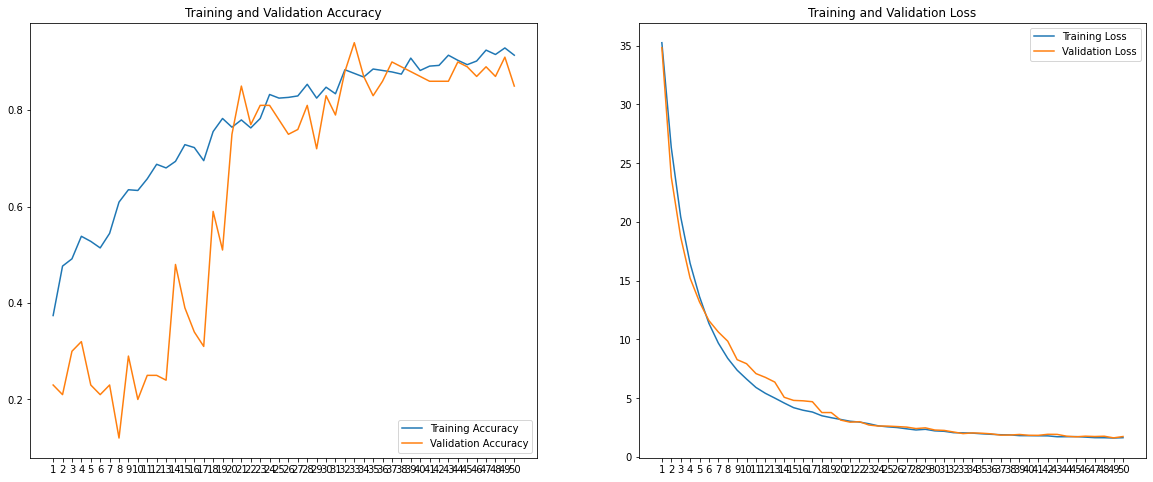

In [10]:
trainer.plot_training_history()

#### Conclusion 

- Our best conv3d model so far. It has training accuracy of 0.93 and validation accuracy of 0.91. 
- We’re wrapping up our experiments with Conv3D models. Next, we’ll try CNN+RNN.

## CNN+RNN

OK!